In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from wordcloud import WordCloud
import nltk
nltk.download(['stopwords', 'punkt', 'wordnet', 'omw-1.4', 'vader_lexicon'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Reading amazon reviews dataset into pandas dataframe, naming columns and checking the head of the dataset

In [4]:
data = pd.read_csv('amazon_cells_labelled.txt', sep='\t', header=None)
data.columns = ['review', 'original_sentiment']
data.head()

,review,original_sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


EDA: Generate summary of dataframe

In [5]:
data.describe()

,original_sentiment
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


EDA: check for missing values

In [6]:
data.isnull().sum()

,0
review,0
original_sentiment,0


**Part 1: Classification**

Checking for class imbalance before training classification model

In [7]:
print("\n All Data Labels")
print(data.groupby("original_sentiment").count())


 All Data Labels
                    review
original_sentiment        
0                      500
1                      500


Define function to carry out data preprocessing steps

In [8]:
stop_words = nltk.corpus.stopwords.words('english')
def preprocess_text(text):
    tokenized_text = nltk.tokenize.RegexpTokenizer('[a-zA-Z0-9\']+').tokenize(text) #tokenize text
    cleaned_tokens = [token.lower() for token in tokenized_text if token.lower() not in stop_words] #make all lower case, remove stop words
    stemmed_tokens = [nltk.stem.PorterStemmer().stem(clean_token) for clean_token in cleaned_tokens] #stemming
    return stemmed_tokens

Use preprocessing function to apply preprocessing steps to reviews dataset

In [9]:
data['processed_review'] = data['review'].apply(preprocess_text)
data.head()

,review,original_sentiment,processed_review
0,So there is no way for me to plug it in here i...,0,"[way, plug, us, unless, go, convert]"
1,"Good case, Excellent value.",1,"[good, case, excel, valu]"
2,Great for the jawbone.,1,"[great, jawbon]"
3,Tied to charger for conversations lasting more...,0,"[tie, charger, convers, last, 45, minut, major..."
4,The mic is great.,1,"[mic, great]"


Define functions to generate word cloud, to see which words are the most common

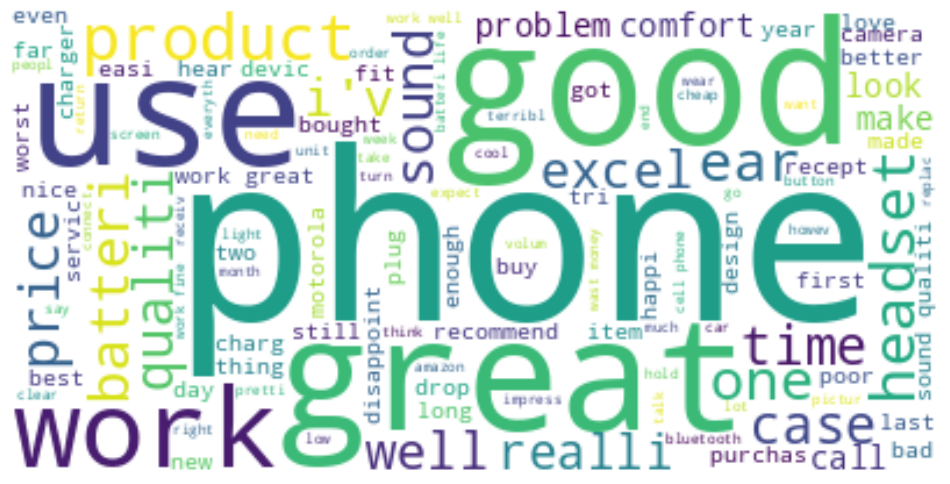

In [10]:
def return_word_list(list_of_list_of_words: list[list[str]]) -> list[str]:
    word_list = []
    for review in list_of_list_of_words:
        for word in review:
            word_list.append(word)
    return word_list

def generate_wordcloud(list_of_words: list[str]):
  wordcloud = WordCloud(background_color='white').generate_from_text(' '.join(list_of_words))
  plt.figure(figsize=(12,12))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

words = return_word_list(data['processed_review'])
generate_wordcloud(words)

Generate Term Frequency Matrix using CountVectorizer in Scikit Learn

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X=vectorizer.fit_transform(data['processed_review'].map(''.join))
X=pd.DataFrame(X.toarray())
X.head()

,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,1000,1001,1002,1003
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


use train_test_split to split the data into the training and test datasets

In [12]:
from sklearn.model_selection import train_test_split

y = data['original_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,test_size=0.2,random_state=99)

Instantiate Multinomial Naïve Bayes classifier model then use the fit method to train the model on the training dataset

In [13]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

Evaluate performance of model by computing the accuracy and generating a confusion matrix

In [14]:
y_pred = model.predict(X_test)

from sklearn import metrics
acc = metrics.accuracy_score(y_test, y_pred)
print('accuracy:%.2f\n\n'%(acc))
cm = metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm,'\n\n')
print('-----------------------------------')
result = metrics.classification_report(y_test, y_pred)
print("Classification Report:",'\n',)
print(result)

accuracy:0.53


Confusion Matrix:
[[96  0]
 [95  9]] 


-----------------------------------
Classification Report: 

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        96
           1       1.00      0.09      0.16       104

    accuracy                           0.53       200
   macro avg       0.75      0.54      0.41       200
weighted avg       0.76      0.53      0.40       200



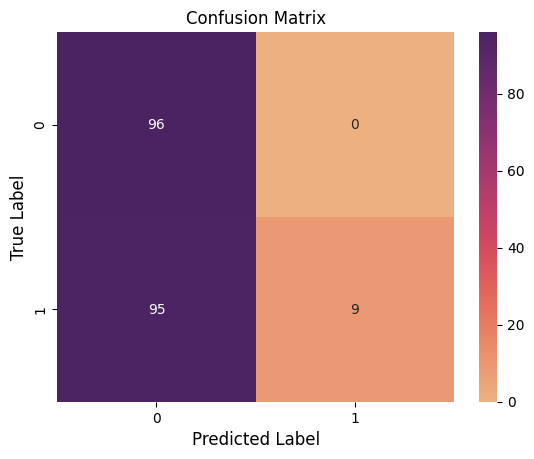

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix = confusion_matrix(y_test,y_pred)

ax = sns.heatmap(confusion_matrix, cmap='flare', annot=True, fmt='d')

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=12)

plt.show()

**Part 2: Sentiment analysis**

Generate polarity scores for sentences in review column using SentimentIntensityAnalyzer

In [16]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment = SentimentIntensityAnalyzer()

In [17]:
data['compound'] = [sentiment.polarity_scores(review)['compound'] for review in data['review']]
data['neg'] = [sentiment.polarity_scores(review)['neg'] for review in data['review']]
data['neu'] = [sentiment.polarity_scores(review)['neu'] for review in data['review']]
data['pos'] = [sentiment.polarity_scores(review)['pos'] for review in data['review']]
data.head()

,review,original_sentiment,processed_review,compound,neg,neu,pos
0,So there is no way for me to plug it in here i...,0,"[way, plug, us, unless, go, convert]",-0.3535,0.120,0.880,0.000
1,"Good case, Excellent value.",1,"[good, case, excel, valu]",0.8402,0.000,0.100,0.900
2,Great for the jawbone.,1,"[great, jawbon]",0.6249,0.000,0.423,0.577
3,Tied to charger for conversations lasting more...,0,"[tie, charger, convers, last, 45, minut, major...",-0.6145,0.287,0.713,0.000
4,The mic is great.,1,"[mic, great]",0.6249,0.000,0.423,0.577


Using the describe() method to get a statistical summary of the sentiment scores

In [18]:
data[['compound', 'neg', 'neu', 'pos']].describe()

,compound,neg,neu,pos
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.137342,0.105039,0.692103,0.202865
std,0.452209,0.191490,0.245514,0.244833
min,-0.925300,0.000000,0.000000,0.000000
25%,-0.271600,0.000000,0.529250,0.000000
50%,0.000000,0.000000,0.720500,0.114000
75%,0.571900,0.161250,0.880250,0.375000
max,0.953800,1.000000,1.000000,1.000000


Using histograms to visualise the distribution of the compound, positive and negative scores

<Axes: xlabel='compound', ylabel='Count'>

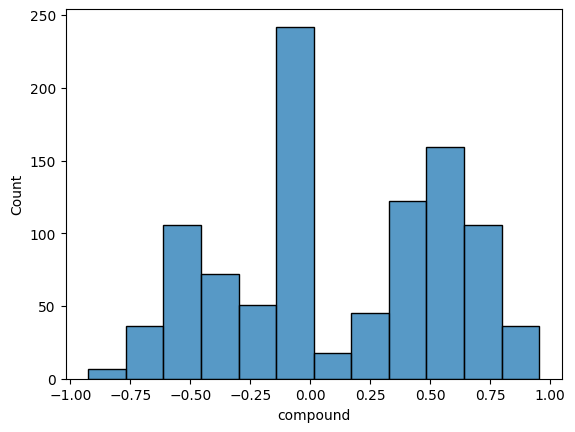

In [19]:
sns.histplot(data['compound'])

<Axes: xlabel='pos', ylabel='Count'>

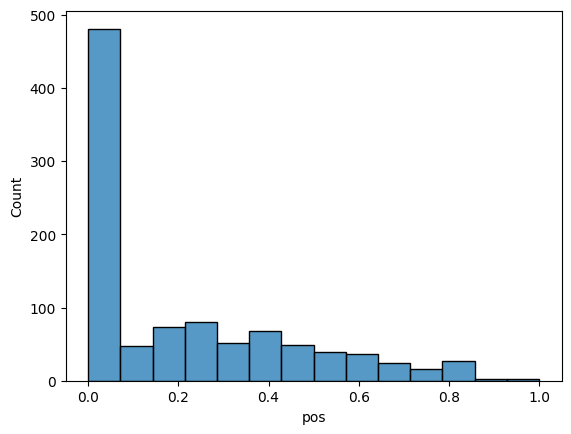

In [20]:
sns.histplot(data['pos'])

<Axes: xlabel='neg', ylabel='Count'>

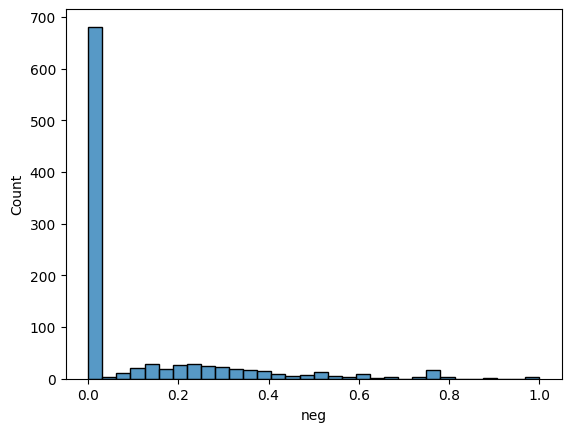

In [21]:
sns.histplot(data['neg'])

Word cloud for negative and positive reviews

In [22]:
data_positive_subset = data.loc[(data['compound']>0),:]
data_negative_subset = data.loc[(data['compound']<0),:]
data_positive_subset.head()

,review,original_sentiment,processed_review,compound,neg,neu,pos
1,"Good case, Excellent value.",1,"[good, case, excel, valu]",0.8402,0.0,0.100,0.900
2,Great for the jawbone.,1,"[great, jawbon]",0.6249,0.0,0.423,0.577
4,The mic is great.,1,"[mic, great]",0.6249,0.0,0.423,0.577
6,If you have several dozen or several hundred c...,0,"[sever, dozen, sever, hundr, contact, imagin, ...",0.5106,0.0,0.858,0.142
10,And the sound quality is great.,1,"[sound, qualiti, great]",0.6249,0.0,0.549,0.451


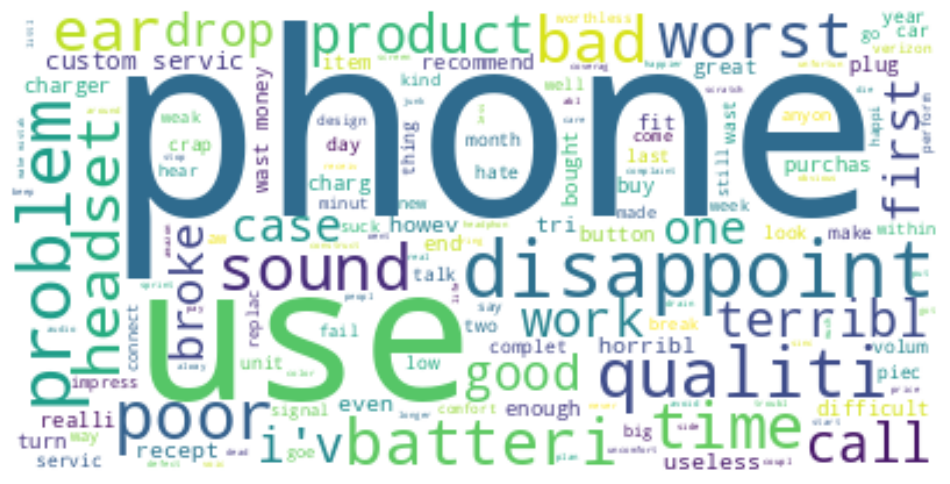

In [23]:
neg_tokens = return_word_list(data_negative_subset['processed_review'])
generate_wordcloud(neg_tokens)

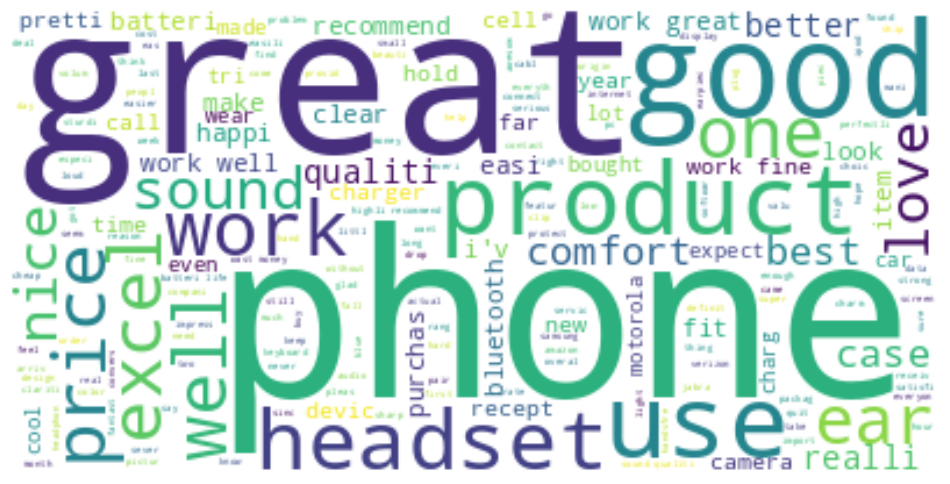

In [24]:
pos_tokens = return_word_list(data_positive_subset['processed_review'])

generate_wordcloud(pos_tokens)

Checking number of occurences of most frequent words in positive and negative reviews

In [25]:
from nltk.probability import FreqDist

pos_freqdist = FreqDist(pos_tokens)
pos_freqdist.tabulate(10)

  great   phone    work    good     use    well product headset   sound   price 
     89      86      68      66      38      38      36      35      30      28 


<Axes: xlabel='Samples', ylabel='Counts'>

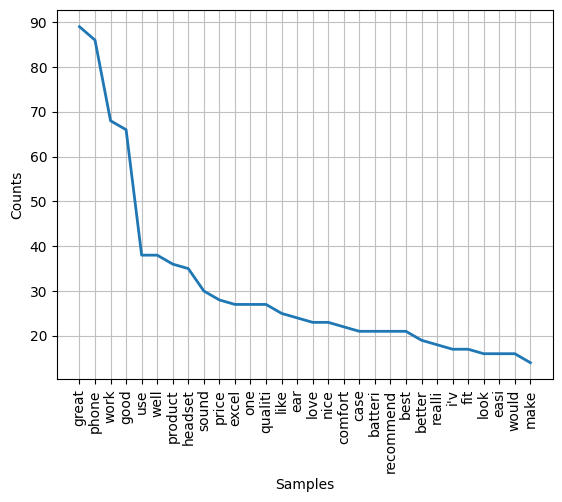

In [26]:
pos_freqdist.plot(30)

In [27]:
neg_freqdist = FreqDist(neg_tokens)
neg_freqdist.tabulate(10)

     phone        use disappoint    problem    qualiti       poor       time    batteri      sound      worst 
        48         22         20         18         16         15         14         14         14         14 


<Axes: xlabel='Samples', ylabel='Counts'>

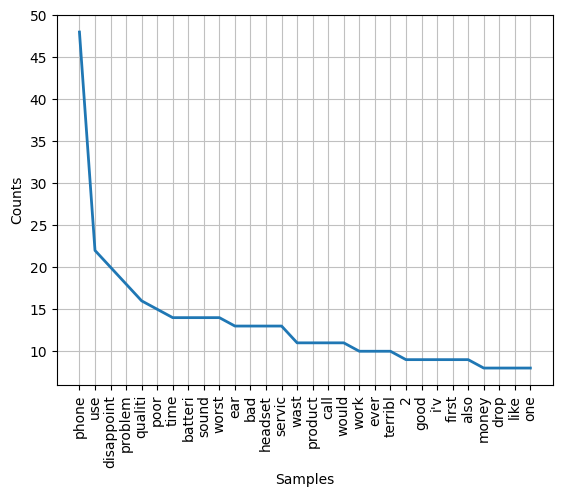

In [28]:
neg_freqdist.plot(30)